# Predicting if an Amazon review from the 'Toys and Games' section is positive (>3 stars) based on the text review

### Evan Bicher 2018

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Get the data
# It can be found here http://jmcauley.ucsd.edu/data/amazon/


df = pd.read_json('../../../Data/Toys_and_Games_5.json', lines=True)

In [3]:
# Check out the data, we really only need the scores and text
df.head()

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,0439893577,"[0, 0]",5,I like the item pricing. My granddaughter want...,"01 29, 2014",A1VXOAVRGKGEAK,Angie,Magnetic board,1390953600
1,0439893577,"[1, 1]",4,Love the magnet easel... great for moving to d...,"03 28, 2014",A8R62G708TSCM,Candace,it works pretty good for moving to different a...,1395964800
2,0439893577,"[1, 1]",5,Both sides are magnetic. A real plus when you...,"01 28, 2013",A21KH420DK0ICA,capemaychristy,love this!,1359331200
3,0439893577,"[0, 0]",5,Bought one a few years ago for my daughter and...,"02 8, 2014",AR29QK6HPFYZ4,dcrm,Daughters love it,1391817600
4,0439893577,"[1, 1]",4,I have a stainless steel refrigerator therefor...,"05 5, 2014",ACCH8EOML6FN5,DoyZ,Great to have so he can play with his alphabet...,1399248000


In [4]:
#Create new DF
data_df = pd.DataFrame()


#Put sections we need into it
data_df['text'] = df['reviewText'].str.lower()
data_df['positive'] = (df['overall']>3).astype(int)
data_df['score'] = df['overall']

# Make the text data cleaner for word searches
data_df['text'] = data_df['text'].str.replace('\(', '>>')
data_df['text'] = data_df['text'].str.replace('\)', '>>')
data_df['text'] = data_df['text'].str.replace(',', '')
data_df['text'] = data_df['text'].str.replace('.', '')
data_df = data_df.dropna()

# Make positive or negative df, which will be used later, same with the test_df
pos_df = data_df[data_df['positive']==1]
neg_df = data_df[data_df['positive']==0]
test_df = data_df

In [5]:
# Check it out
data_df.head()

,text,positive,score
0,i like the item pricing my granddaughter wante...,1,5
1,love the magnet easel great for moving to diff...,1,4
2,both sides are magnetic a real plus when you'...,1,5
3,bought one a few years ago for my daughter and...,1,5
4,i have a stainless steel refrigerator therefor...,1,4


In [6]:
# Check the text for certain key words and create new columns in the dataframe that show if the keywords are present

keywords = ['good', 'great', 'wonderful', 'sweet', 'suprised', 'awesome', 'perfect', 'nice', 'highly', 'well', 'exactly', 'loves', 'loved']

for key in keywords:
    data_df[str(key)] = data_df.text.str.contains(
        str(key),
        case=True
    )
    
badwords = ['bad', 'awful', 'terrible', 'broken', 'wasted', 'disappoint', 'not good', 'poorly', 'annoy', 'boring']


for badkey in badwords:
    data_df[str(badkey)] = ~data_df.text.str.contains(
        str(badkey),
        case=True
    )


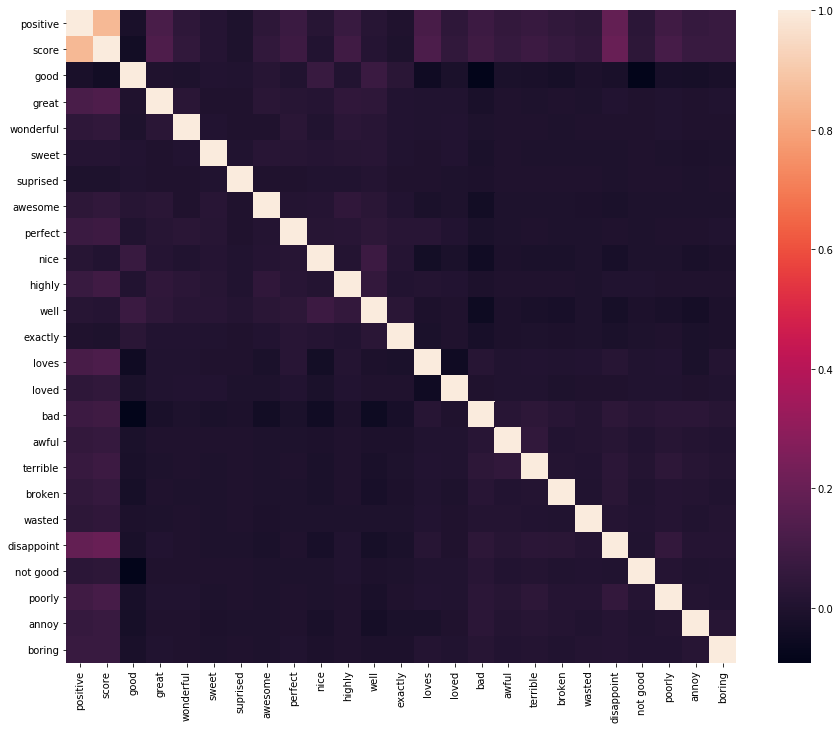

In [7]:
#Check the correlation

plt.subplots(figsize=(15, 12))
sns.heatmap(data_df.corr())


In [8]:
from sklearn.naive_bayes import BernoulliNB

# Use the keyword / badword binary columns to decide

data = data_df[keywords + badwords]
target = data_df['positive']


bnb = BernoulliNB()
bnb.fit(data, target)


y_pred = bnb.predict(data)

# Display our results.
print('\n**********************************************************************')
print('**********************************************************************')
print("Number of mislabeled points out of a total {} points : {}".format(
    data.shape[0],
    (target != y_pred).sum()
))
print('\n**********************************************************************')
print('**********************************************************************')
print('Accuracy: ')
print(1-((target != y_pred).sum()/data.shape[0]))





**********************************************************************
**********************************************************************
Number of mislabeled points out of a total 167597 points : 25676

**********************************************************************
**********************************************************************
Accuracy: 
0.8467991670495295


In [9]:
from sklearn.metrics import confusion_matrix
# Confusion matrix to see where our mistakes are coming from


confusion_matrix(target, y_pred)

array([[  3563,  23799],
       [  1877, 138358]])

 I think we can do better! Let's try RFC

In [10]:

#Trying RFC with the same words

from sklearn import ensemble
from sklearn.model_selection import cross_val_score
from numpy.core.umath_tests import inner1d

rfc = ensemble.RandomForestClassifier()
X = data_df.drop(['positive', 'score', 'text'], 1)
Y = data_df['positive']

cross_val_score(rfc, X, Y, cv=5)




/home/ebicher/.local/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


array([0.84606205, 0.8449284 , 0.84596796, 0.84364092, 0.84393926])

Thats a bit better but I think we can do more!

In [11]:
# I will compile a list for what unique words are contained in good reviews and not negative reviews
# 

import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
  

def find_good_count():
    
    good_words = {}
    
    
    
    for row in pos_df['text']:
        
        
        text = row.replace(".", "")
        text = text.replace("!", "")
        text = text.replace(",", "")
        text = row.split()
        
        for word in text:
            
            if word in good_words:
                good_words[word] = good_words[word]+1
            else:
                good_words[word] = 1
            
            
    return (good_words)


def find_bad_count():
    
    bad_words = {}
    
    
    
    for row in neg_df['text']:
        
        
        text = row.replace(".", "")
        text = text.replace("!", "")
        text = text.replace(",", "")
        text = row.split()
        
        for word in text:
            
            if word in bad_words:
                bad_words[word] = bad_words[word]+1
            else:
                bad_words[word] = 1
            
            
    return (bad_words)

    

In [12]:
dfp = find_good_count()
dfn = find_bad_count()

In [13]:
pos_words = pd.DataFrame.from_dict(dfp, orient='index', columns=['Count'])
neg_words = pd.DataFrame.from_dict(dfn, orient='index', columns=['Count'])

In [14]:
all_words = pos_words
all_words = all_words['Count'] - neg_words['Count']
all_words = all_words.drop(['the', 'and', 'a', 'to', 'it', 'is', 'for', 'i', 'with', 'my', 'that', 'in', 'are', 'you', 'on'])

In [15]:
good = all_words.sort_values(ascending=False).head(40)
bad = all_words.sort_values(ascending=True).head(60)

In [23]:
keywords = ['good', 'great', 'nice', 'highly', 'well', 'works', 'exactly', 'loves', 'loved']

for key in keywords:
    data_df[str(key)] = test_df.text.str.contains(
        str(key),
        case=True
    )

badwords = list(bad.index.values)


for badkey in badwords:
    
    test_df[str(badkey)] = ~test_df.text.str.contains(
        str(badkey),
        case=True
    )

In [24]:



data = test_df[keywords+badwords]
target = test_df['positive']


bnb = BernoulliNB()
bnb.fit(data, target)


y_pred = bnb.predict(data)

print('\n**********************************************************************')
print('**********************************************************************')
print("Number of mislabeled points out of a total {} points : {}".format(
    data.shape[0],
    (target != y_pred).sum()
))
print('\n**********************************************************************')
print('**********************************************************************')
print('Accuracy: ')
print(1-((target != y_pred).sum()/data.shape[0]))

confusion_matrix(target, y_pred)




**********************************************************************
**********************************************************************
Number of mislabeled points out of a total 167597 points : 23904

**********************************************************************
**********************************************************************
Accuracy: 
0.8573721486661456


array([[  7571,  19791],
       [  4113, 136122]])

In [25]:
from sklearn import ensemble
from sklearn.model_selection import cross_val_score
from numpy.core.umath_tests import inner1d

rfc = ensemble.RandomForestClassifier()
X = test_df.drop(['positive', 'score', 'text'], 1)
Y = test_df['positive']

cross_val_score(rfc, X, Y, cv=5)



array([0.85602625, 0.85599642, 0.85876667, 0.85497777, 0.8524419 ])